<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

#### <span style="color:darkred">__Part 1: Data Exploration__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-exploration.ipynb </span><br><br><span style="color:darkred">__Part 2: Models__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-models.ipynb </span>

----

# <span style="color:darkred">Part 1: </span><span style="color:darkblue">L1 Prediction from ELL Writing Samples</span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__
> http://lang-8.com/ [scraped with Beautiful Soup]

![alt text](../data/language/lang8.png "Title")

__Summary:__
> In my previous profession, I have been teaching English to a diverse range of students of all ages, language background, and country origin. During my professional development, I started to observe that different students with different L1s (1st Language) tended to display different patterns of communication that appeared to have some connection to either education in their country of origin or a connection to the linguistic structure of their first language. Different ELL (English Language Learners) needed to focus on different aspects of the English language depending on their background. The purpose of this project is to use a large number of blog posts from a language practicing website and explore whether or not the L1 has any significant impact on the blog writing style of the English learner.<br><br>Part 1: Explore the data to find any noteworthy trends in linguistic structure: <ol><li> vocabulary (word freq, collocations, and cognates) <li>syntax (sentence structure)<li>grammar (i.e. grammar complexity of sentences) <li>errors (types of errors) <li> parts of speech (NLTK Abbreviations: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/)</ol><br>Part 2: Use linguistic trends to determine whether or not a learner's first language can be predicted.

__Variables:__
>__id:__ _User ID_<br>
__time:__ _Time the blog post was scraped (in order of user posted time)_ <br>
__title:__ _Title of the blog post_<br>
__content:__ _The blog post_<br>
__language:__ _User's self-reported first language_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Hypothesis:__ 
> L1 (first language) experience and academic environment influences ELLs' (English Language Learners') writing style. The L1 of ELLs can be predicted by looking at English blog posts and identifying patterns unique to their L1.

__Observations:__
><li> --<li>--<li>--

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

http://www.anc.org/data/anc-second-release/frequency-data/

<a id="sec1"></a>

# <span style="color:darkblue">1. Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# from nltk.corpus import brown
# nltk.download('brown')

In [2]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

# Data processing
import scipy
import pandas as pd
import plotly as plo
import seaborn as sns
from collections import Counter
import re

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, median_test, f_oneway

# NLP
import textblob
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib
from string import punctuation

# import altair as alt

In [3]:
# load and close files
def get_text(link):
    with open(link) as f:
        output = f.read()
    return output

In [4]:
# Jupyter Settings and Imports
%pylab
%matplotlib inline 
warnings.filterwarnings(action='once')

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [5]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')
blog.info()

# POS Table for reference
poscv = pd.read_csv('../data/pos.csv')
poscv = poscv.iloc[0:17]
poscv.columns = ['Set1','Set 2']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17141 entries, 0 to 17140
Data columns (total 6 columns):
Unnamed: 0    17141 non-null int64
id            17141 non-null int64
time          17141 non-null object
title         17141 non-null object
content       17141 non-null object
language      17141 non-null object
dtypes: int64(2), object(4)
memory usage: 803.6+ KB


In [6]:
# Import data
blog = pd.read_csv('../data/language/blogdata-reduced.csv')

# Clean Data
del blog['Unnamed: 0']
blog.language = blog.language.mask(blog.language == 'Mandarin', 'Traditional Chinese').replace(['Persian', 'Arabic',
        'Bulgarian', 'Swedish', 'Slovenian', 'Slovak', 'Malay', 'Turkish','Romanian', 'Czech', 'Danish', 'Vietnamese',
        'Norwegian','Serbian','Other language','Lithuanian', 'Ukrainian', 'Finnish','Estonian','Bengali','Russian', 
        'Spanish','French', 'German', 'Cantonese','Mongolian', 'Tagalog', 'Polish', 'Dutch','Italian', 'Portuguese(Brazil)', 
        'Thai', 'Indonesian', 'Cantonese','Urdu', 'Hungarian'], np.nan)
blog = blog.dropna().sample(frac=1)

del blog['title']
del blog['time']

In [7]:
blog.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15724 entries, 11020 to 8201
Columns: 3 entries, id to language
dtypes: int64(1), object(2)

In [8]:
blog.head()

,id,content,language
11020,3218,"Hello, this is Wasabi from Japan. This mornin...",Japanese
2271,605,"when we talk about Fukuoka city, sometimes cal...",Japanese
14959,4410,I think Sumo is different from other sports. S...,Japanese
16610,4905,"Our office is located in Shinjuku, Tokyo-metro...",Japanese
4610,1117,"Hi, this is my first time to visit this websit...",Japanese


In [9]:
# Confirmation that there are no more null values
blog.isnull().values.any()

False

In [10]:
def lettercheck(val):
    reLetters = re.compile('[^a-zA-Z]')
    onlyletters = reLetters.sub('', val)
    return len(onlyletters)/len(val)

In [11]:
blog['letters_per'] = blog.content.apply(lettercheck)
print('Removing Blogs with less than 70% letter percentage: {}'.format(blog.loc[blog['letters_per'] <= .7].content.count()))
blog = blog.loc[blog['letters_per'] > .7]

Removing Blogs with less than 70% letter percentage: 1491


In [12]:
blog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14233 entries, 11020 to 8201
Data columns (total 4 columns):
id             14233 non-null int64
content        14233 non-null object
language       14233 non-null object
letters_per    14233 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 556.0+ KB


<a id="sec2"></a>

# <span style="color:darkblue">2. Exploring the Data</span>  <a href='#top'>(top)</a>

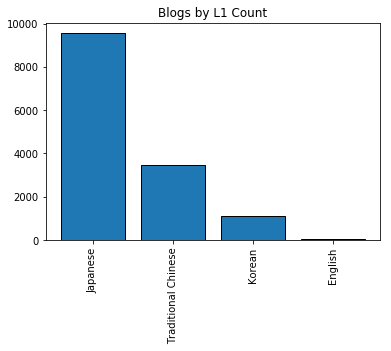

In [13]:
vals = list(blog.language.value_counts().values)
languages = list(blog.language.value_counts().index)
plt.figure(figsize(6,4))
plt.bar(languages,vals,edgecolor='black')
plt.title('Blogs by L1 Count')
plt.xticks(rotation='vertical')
plt.show()

In [14]:
print("Posts by 'Native' English Speakers: {}".format(blog.id.loc[blog.language == 'English'].count()))

Posts by 'Native' English Speakers: 69


<a id="nlp"></a>

### <span style="color:darkred">NLP: Spell Check, Tokenization, Collocations, Parts of Speech, and Syntax</span>  <a href='#top'>(top)</a>

__Word Level Ranking__

In [15]:
ANCI_WORDS = pd.read_csv('../data/language/ANC-written-count.txt', 
                         sep='\t', 
                         encoding='latin-1', 
                         names=['word','stem','pos','freq'],header=None)

In [16]:
a = ANCI_WORDS['word'].values
b = ANCI_WORDS['freq'].values
word_freq = list(zip(a,b))

In [17]:
full_words_dict = {}
i = 0

for w in word_freq:
    i = i + 1
    
    if w[0] not in full_words_dict:
        full_words_dict[w[0]] = w[1]

In [18]:
words_dict = {}
i = 0

for w in word_freq:
    i = i + 1
    
    if w[0] not in words_dict:
        if i < 500:
            words_dict[w[0]] = 1
        elif (i >= 500) & (i < 5000):
            words_dict[w[0]] = 2
        elif (i >= 5000) & (i < 10000):
            words_dict[w[0]] = 3
        elif (i >= 5000) & (i < 20000):
            words_dict[w[0]] = 4

In [19]:
def freq_rating(l):
    score = 0
    c=0
    for w in l:
        if w in words_dict:
            c = c + 1
            score = score + words_dict[w]
    if c == 0:
        c=1
    return score / c

In [20]:
def full_freq_rating(l):
    score = 0
    c=0
    for w in l:
        if w in full_words_dict:
            c = c + 1
            score = score + full_words_dict[w]
    if c == 0:
        c=1
    return score / c

__TextBlob__

In [21]:
%%time
blob = blog.content.apply(lambda val: textblob.TextBlob(val))

CPU times: user 218 ms, sys: 6.09 ms, total: 224 ms
Wall time: 234 ms


In [22]:
def posbigram(val):
    l = []
    bigramlist = []
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        bigrm = list(nltk.bigrams(l))
        
        for bigram in bigrm:
            bigramlist.append('-'.join(bigram))
        
    return bigramlist

def postrigram(val):
    l = []
    trigramlist = []
    
    for s in val.sentences:
        ns = textblob.TextBlob(str(s)).tags
        l = [v[1] for v in ns]
        trigrm = list(nltk.trigrams(l))
        
        for trigram in trigrm:
            trigramlist.append('-'.join(trigram))
        
    return trigramlist

In [23]:
%%time
blog['wc'] = blob.apply(lambda val: len(val.words))
blog['sc'] = blob.apply(lambda val: len(val.sentences))
blog['tokens'] = blob.apply(lambda val: [w.lower() for w in val.words])
blog['pos'] = blob.apply(lambda val: [v[1] for v in val.tags])
blog['nns'] = blob.apply(lambda val: val.noun_phrases)
blog['sent_pol'] = blob.apply(lambda val: val.sentiment[0])
blog['sent_subj'] = blob.apply(lambda val: val.sentiment[1])

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/corpus/reader/api.py:322: ResourceWarning:

unclosed file <_io.BufferedReader name='/Users/ryan/nltk_data/corpora/brown/cats.txt'>



CPU times: user 3min 12s, sys: 10.8 s, total: 3min 23s
Wall time: 3min 33s


In [24]:
%%time
blog['pos2'] = blob.apply(posbigram)

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/util.py:491: DeprecationWarning:

generator 'ngrams' raised StopIteration



CPU times: user 1min 48s, sys: 2.04 s, total: 1min 50s
Wall time: 1min 55s


In [25]:
%%time
blog['pos3'] = blob.apply(postrigram)

/Users/ryan/anaconda3/lib/python3.6/site-packages/nltk/util.py:510: DeprecationWarning:

generator 'ngrams' raised StopIteration



CPU times: user 1min 49s, sys: 2.25 s, total: 1min 51s
Wall time: 1min 52s


In [26]:
blog['freq_score'] = blob.apply(lambda val: freq_rating(val.words))
blog['full_freq_score'] = blob.apply(lambda val: full_freq_rating(val.words))

__Data Cleaning Round 2__

In [27]:
blog = blog[blog['wc'] >= 4]
blog = blog[blog['full_freq_score'] > 1500]

__Backup File__

<a id="feature"></a>

# <span style="color:darkblue">2. Feature Processing:</span>  <a href='#top'>(top)</a>

In [28]:
def create_dummy_count_df(df,col,name,keep=[],):
    colset = set(df[col].sum())
    finalsetlist = []
    if len(keep) > 0:
        colset = [k for k in keep if k in colset]
    
    for c in colset:
        colname = name+'_'+str(c)
        df[colname] = df[col].apply(lambda val: val.count(c))
        
        if df[colname].sum() < 1:
            del df[colname]
        else:
            finalsetlist.append(colname)
        
    print('Created dummy counter for {} features'.format(name))
        
    return finalsetlist

In [29]:
letters1 = []
for let in 'abcdefghijklmnopqrstuvwxyz':
    name = 'let1_'+let
    blog[name] = blog.tokens.apply(lambda val: ''.join(val).count(let))
    letters1.append(name)

In [30]:
%%time
alphabet = list('abcdefghijklmnopqrstuvwxyz')
letters2 = []
for let in alphabet:
    for let2 in alphabet:
        letters2.append(let+let2)

letters2name = []        
for let in letters2:
    name = 'let2_'+let
    blog[name] = blog.tokens.apply(lambda val: ' '.join(val).count(let))
    if blog[name].sum() < 10:
        del blog[name]
    else:
        letters2name.append(name)
        
letters2 = letters2name

CPU times: user 38.3 s, sys: 441 ms, total: 38.7 s
Wall time: 39.5 s


In [31]:
%%time
prplist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'PRP'])
pronouns = create_dummy_count_df(blog,'tokens','prp',prplist)

Created dummy counter for prp features
CPU times: user 1min 54s, sys: 31 s, total: 2min 25s
Wall time: 2min 27s


In [32]:
%%time
cclist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'CC'])
coordinators = create_dummy_count_df(blog,'tokens','cc',cclist)

Created dummy counter for cc features
CPU times: user 1min 53s, sys: 31.3 s, total: 2min 25s
Wall time: 2min 27s


In [33]:
%%time
inlist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'IN'])
preposition = create_dummy_count_df(blog,'tokens','prep',inlist)

Created dummy counter for prep features
CPU times: user 1min 55s, sys: 30.8 s, total: 2min 26s
Wall time: 2min 28s


In [34]:
%%time
adverblist = list(ANCI_WORDS['word'][ANCI_WORDS.pos == 'RB'])[0:50]
adverb = create_dummy_count_df(blog,'tokens','adv',adverblist)

Created dummy counter for adv features
CPU times: user 1min 47s, sys: 29.3 s, total: 2min 16s
Wall time: 2min 16s


In [35]:
%%time
pos2 = create_dummy_count_df(blog,'pos2','pos2')
pos1 = create_dummy_count_df(blog,'pos','pos1')

Created dummy counter for pos2 features
Created dummy counter for pos1 features
CPU times: user 3min 12s, sys: 54.9 s, total: 4min 7s
Wall time: 4min 11s


In [ ]:
%%time
pos3 = create_dummy_count_df(blog,'pos3','pos3')

In [ ]:
%%time
blog.to_csv('blogfeatures.csv')
# features_user.to_csv('userblogfeatures.csv')

__Bar Plots__

_There is a lower English sample count so higher variance is expected._

In [ ]:
from scipy.stats import shapiro

__Reject Outliers__

In [ ]:
from statsmodels import robust

def MEDIAN_reject_outliers(data, m=3):
    data = data[(data - np.median(data)) < m*robust.mad(data)]
    return data[~numpy.isnan(data)].sort_values()


def MEAN_reject_outliers(data, m=3):
    data = data[abs(data - np.mean(data)) < m*np.std(data)]
    return data[~numpy.isnan(data)].sort_values()

# lanlenseries = [reject_outliers(blog.char_count[blog.language == l]) for l in list(blog.language.unique())]

__Create Analysis Set__

In [ ]:
import_features = ['let2_ja', 'pos2_PRP-VBD', 'let2_ko', 'sc', 'wc', 'let2_he', 'let2_ap', 'let2_nw', 'let2_ea', 
                   'let2_rn', 'let2_yb', 'let2_wh', 'let2_ku', 'let2_el', 'pos2_NN-MD', 'let2_th', 'let2_pa', 
                   'pos2_CD-NN', 'sent_subj', 'prep_that', 'let2_io', 'pos2_NNS-RB', 'pos2_PRP-CC', 'let2_hq']
full_features = import_features + ['language']


analysis = blog[full_features]
# analysis2 = analysis.groupby(['id','language']).mean()
# analysis2.reset_index(inplace=True)
# print("'Native' English Speaker Count: {}".format(analysis2.id.loc[analysis2.language == 'English'].count()))

__Plot Hist__

_POS Features_

In [ ]:
lang = list(blog.language.unique())
i = 1
fig=plt.figure(figsize=(15,15))
for pos in pos1:
    plt.subplot(6, 6, i)
    i = i + 1
    
    for g in [MEDIAN_reject_outliers(blog[pos][blog.language == l],3) for l in lang]:
        sns.kdeplot(g,legend=None,kernel='gau',shade=True)
#         plt.hist(g,alpha=0.8)
        plt.title(pos)

fig.suptitle('Histograms of POS Features', fontsize=18, y=1.03)
plt.tight_layout()
plt.legend(lang)
plt.show()

In [ ]:
for c in pos1:
    p = shapiro(blog[c])[1]
    if (p < .05) & (p > 0):
        print('{}:\x1b[92m{}\x1b[0m'.format(c,p),end='|')
    elif p > .05:
        print('{}:\x1b[31m{}\x1b[0m'.format(c,p),end='|')
    else:
        print('{}:\x1b[33m{}\x1b[0m'.format(c,p),end='|')

_Decision Tree Truncated SVD Features_

In [ ]:
for c in import_features:
    p = shapiro(blog[c])[1]
    if (p < .05) & (p > 0):
        print('{}:\x1b[92m{}\x1b[0m'.format(c,p),end='|')
    elif p > .05:
        print('{}:\x1b[31m{}\x1b[0m'.format(c,p),end='|')
    else:
        print('{}:\x1b[33m{}\x1b[0m'.format(c,p),end='|')

In [ ]:
exclude = ['id','content','language','tokens','pos','pos2','pos3']

In [ ]:
goodlist = []
for c in list(blog.columns):
    if c not in exclude:

        p = shapiro(blog[c])[1]
        if (p < .05) & (p > 0):
            print('{}:\x1b[92m{}\x1b[0m'.format(c,p),end='|')
            goodlist.append(c)   
        elif p > .05:
            print('{}:\x1b[31m{}\x1b[0m'.format(c,p),end='|')
        else:
            pass
#             print('{}:\x1b[33m{}\x1b[0m'.format(c,p),end='|')


In [ ]:
goodlist

__Correlations (of top features by decision tree importance)__

In [ ]:
# corr = analysis.corr(); print(corr)
i = 1
fig=plt.figure(figsize=(22,10))

for ind,g in enumerate([(analysis[import_features[0:5]][analysis.language == l]) for l in lang]):
    plt.subplot(2, 2, i)
    i = i + 1
    
    corr = g.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True)
    plt.title(lang[ind])
    plt.xticks(rotation='vertical',fontsize = 9)
    plt.yticks(rotation='horizontal',fontsize = 7)
    
plt.show()

<a id="sec3"></a>

###  <span style="color:darkblue">C. Statistical Significance <a href='#top'>(top)</a>

In [ ]:
def mw_test(a,b):
    stat,p = mannwhitneyu(a,b, use_continuity=True, alternative=None)
    return stat,p

def mood_test(a,b,c,d):
    stat, p, med, tbl = median_test(a,b,c,d)
    return stat,p

def f1way_test(a,b,c,d):
    f,b = f_oneway(a,b,c,d)
    return f,b

import warnings
warnings.filterwarnings('ignore')

__Mann Whitney U test (2 Non-Normally Distributed Independent Samples)__

In [ ]:
print('[Japanese -- Chinese]')

for pos in import_features:
    g = [MEDIAN_reject_outliers(analysis[pos][analysis.language == l]) for l in lang]
    stat,p = mw_test(g[0],g[1])
    vals = 'stat={}, p={}'.format(stat,p)
    if p < .05:
        print('{}:\x1b[92m{}\x1b[0m'.format(pos,vals))
    else:
        print('{}:\x1b[31m{}\x1b[0m'.format(pos,vals))
poscv

__B. Mood’s Median test (2+ Non-Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

In [ ]:
for pos in import_features:
    g = [(analysis[pos][analysis.language == l]) for l in lang]
    
    stat,p = mood_test(g[0],g[1],g[2],g[3])
    vals = 'stat={}, p={}'.format(stat,p)
    if p < .05:
        print('{}:\x1b[92m{}\x1b[0m'.format(pos,vals))
    else:
        print('{}:\x1b[31m{}\x1b[0m'.format(pos,vals))

In [ ]:
# print(len(*blog['language'].isin(lang)))

p-value is less than 5% and disproves the null hypothesis. With regards to error percentage, L1 language samples have different distributions.

__B. One-Way AnovaTest (2+ Normally Distributed Independent Samples)__

__Null Hypothesis:__ Assumes samples are from same 1st language population.

In [ ]:
for pos in import_features:
    g = [(analysis[pos][analysis.language == l]) for l in lang]
    
    f,b = f1way_test(g[0],g[1],g[2],g[3])
    vals = 'f={}, b={}'.format(f,b)
    if b < .05:
        print('{}:\x1b[92m{}\x1b[0m'.format(pos,vals))
    else:
        print('{}:\x1b[31m{}\x1b[0m'.format(pos,vals))

p-value is less than 5% and disproves the null hypothesis. L1 samples have different distributions.

<a id="output"></a>